In [2]:
import os
from sys import displayhook
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import paddle
import paddle.fluid as fluid
import paddle.fluid.layers as layers
from multiprocessing import cpu_count
from paddle.fluid.dygraph import Pool2D, Conv2D
from paddle.fluid.dygraph import Linear

KeyboardInterrupt: 

<>:2: DeprecationWarning: invalid escape sequence \P
<>:2: DeprecationWarning: invalid escape sequence \P
<ipython-input-5-d944f17acefd>:2: DeprecationWarning: invalid escape sequence \P
  data_path = 'F:\PhotonElectric\RaspberryLuigi\paddle_gesture-master\Dataset\Dataset'
['.DS_Store', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Your list has benn generated
train_pass:0,batch_id:50,train_loss:[0.03401373],train_acc:[1.]
train_pass:0,batch_id:100,train_loss:[0.85323364],train_acc:[0.6875]
train_pass:1,batch_id:50,train_loss:[0.04591731],train_acc:[1.]
train_pass:1,batch_id:100,train_loss:[0.74414045],train_acc:[0.78125]
train_pass:2,batch_id:50,train_loss:[0.04609927],train_acc:[1.]
train_pass:2,batch_id:100,train_loss:[0.84493804],train_acc:[0.71875]
train_pass:3,batch_id:50,train_loss:[0.04090667],train_acc:[1.]
train_pass:3,batch_id:100,train_loss:[0.60836244],train_acc:[0.8125]
train_pass:4,batch_id:50,train_loss:[0.02357407],train_acc:[1.]
train_pass:4,batch_id:100,train_los

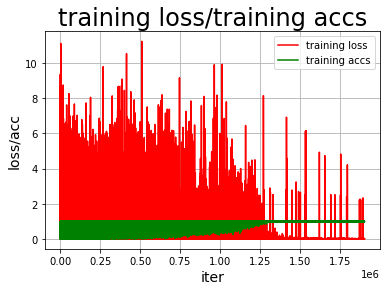

In [ ]:
# Generate picture list
data_path = 'F:\PhotonElectric\RaspberryLuigi\paddle_gesture-master\Dataset\Dataset'
character_folders = os.listdir(data_path)
print(character_folders)
if (os.path.exists('./train_data.list')):
    os.remove('./train_data.list')
if (os.path.exists('./test_data.list')):
    os.remove('./test_data.list')

for character_folder in character_folders:
    with open('./train_data.list', 'a') as f_train:
        with open('./test_data.list', 'a') as f_test:
            if character_folder == '.DS_Store':
                continue
            character_imgs = os.listdir(os.path.join(data_path, character_folder))
            count = 0
            for img in character_imgs:
                if img == '.DS_Store':
                    continue
                if count % 10 == 0:
                    f_test.write(os.path.join(data_path, character_folder, img) + '\t' + character_folder + '\n')
                else:
                    f_train.write(os.path.join(data_path, character_folder, img) + '\t' + character_folder + '\n')
                count += 1
print('Your list has benn generated')


# reader for train_set and test_set
def data_mapper(sample):
    img, label = sample
    img = Image.open(img)
    img = img.resize((32, 32), Image.ANTIALIAS)
    img = np.array(img).astype('float32')
    img = img.transpose((2, 0, 1))
    img = img / 255.0
    return img, label


def data_reader(data_list_path):
    def reader():
        with open(data_list_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                img, label = line.split('\t')
                yield img, int(label)

    return paddle.reader.xmap_readers(data_mapper, reader, cpu_count(), 512)


train_reader = paddle.batch(reader=paddle.reader.shuffle(reader=data_reader('./train_data.list'), buf_size=256),
                            batch_size=32)

test_reader = paddle.batch(reader=data_reader('./test_data.list'), batch_size=32)

class MyLeNet(fluid.dygraph.Layer):
    def __init__(self):
        super(MyLeNet, self).__init__()
        self.c1 = Conv2D(3, 6, 5, 1)
        self.s2 = Pool2D(pool_size=2, pool_type='max', pool_stride=2)
        self.c3 = Conv2D(6, 16, 5, 1)
        self.s4 = Pool2D(pool_size=2, pool_type='max', pool_stride=2)
        self.c5 = Conv2D(16, 120, 5, 1)
        self.f6 = Linear(120, 84, act='relu')
        self.f7 = Linear(84, 10, act='softmax')

    def forward(self, input):
        # print(input.shape)
        x = self.c1(input)
        # print(x.shape)
        x = self.s2(x)
        # print(x.shape)
        x = self.c3(x)
        # print(x.shape)
        x = self.s4(x)
        # print(x.shape)
        x = self.c5(x)
        # print(x.shape)
        x = fluid.layers.reshape(x, shape=[-1, 120])
        # print(x.shape)
        x = self.f6(x)
        y = self.f7(x)
        return y

import matplotlib.pyplot as plt

Iter = 0
Iters = []
all_train_loss = []
all_train_accs = []

def draw_train_process(iters, train_loss, train_accs):
    title = 'training loss/training accs'
    plt.title(title, fontsize=24)
    plt.xlabel('iter', fontsize=14)
    plt.ylabel('loss/acc', fontsize=14)
    plt.plot(iters, train_loss, color='red', label='training loss')
    plt.plot(iters, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()


# 用动态图进行训练
with fluid.dygraph.guard():
    model = MyLeNet()  
    model.train()  
    opt = fluid.optimizer.SGDOptimizer(learning_rate=0.01,
                                       parameter_list=model.parameters()) 

    epochs_num = 500  # iteration times

    for pass_num in range(epochs_num):

        for batch_id, data in enumerate(train_reader()):

            images = np.array([x[0].reshape(3, 32, 32) for x in data], np.float32)

            labels = np.array([x[1] for x in data]).astype('int64')
            labels = labels[:, np.newaxis]
            # print(images.shape)
            image = fluid.dygraph.to_variable(images)
            label = fluid.dygraph.to_variable(labels)
            predict = model(image)  
            # print(predict)
            loss = fluid.layers.cross_entropy(predict, label)
            avg_loss = fluid.layers.mean(loss)  

            acc = fluid.layers.accuracy(predict, label)  

            Iter += 32
            Iters.append(Iter)
            all_train_loss.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0])

            if batch_id != 0 and batch_id % 50 == 0:
                print(
                    "train_pass:{},batch_id:{},train_loss:{},train_acc:{}".format(pass_num, batch_id, avg_loss.numpy(),
                                                                                  acc.numpy()))

            avg_loss.backward()
            opt.minimize(avg_loss)
            model.clear_gradients()

    fluid.save_dygraph(model.state_dict(), 'MyLeNet')  # 保存模型
draw_train_process(Iters, all_train_loss, all_train_accs)

In [ ]:
# 模型校验
with fluid.dygraph.guard():
    accs = []
    model_dict, _ = fluid.load_dygraph('MyLeNet')
    model = MyLeNet()
    model.load_dict(model_dict)  # 加载模型参数
    model.eval()  # 训练模式
    for batch_id, data in enumerate(test_reader()):  # 测试集
        images = np.array([x[0].reshape(3, 32, 32) for x in data], np.float32)
        labels = np.array([x[1] for x in data]).astype('int64')
        labels = labels[:, np.newaxis]

        image = fluid.dygraph.to_variable(images)
        label = fluid.dygraph.to_variable(labels)

        predict = model(image)
        acc = fluid.layers.accuracy(predict, label)
        accs.append(acc.numpy()[0])
        avg_acc = np.mean(accs)
    print(avg_acc)


# 读取预测图像，进行预测
def load_image(path):
    img = Image.open(path)
    img = img.resize((32, 32), Image.ANTIALIAS)
    img = np.array(img).astype('float32')
    img = img.transpose((2, 0, 1))
    img = img / 255.0
    print(img.shape)
    return img

0.46517855


(3, 32, 32)


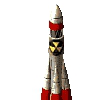

1


In [ ]:
# 构建预测动态图过程
with fluid.dygraph.guard():
    infer_path = 'F:\\PhotonElectric\\RaspberryLuigi\\paddle_gesture-master\\nuke.jpg'
    model = MyLeNet()  # 模型实例化
    model_dict, _ = fluid.load_dygraph('MyLeNet')
    model.load_dict(model_dict)  # 加载模型参数
    model.eval()  # 评估模式
    infer_img = load_image(infer_path)
    infer_img = np.array(infer_img).astype('float32')
    infer_img = infer_img[np.newaxis, :, :, :]
    infer_img = fluid.dygraph.to_variable(infer_img)
    result = model(infer_img)
    displayhook(Image.open('F:\\PhotonElectric\\RaspberryLuigi\\paddle_gesture-master\\nuke.jpg')) #png is wrong for additional aplha channel
    print(np.argmax(result.numpy()))

In [ ]:
data_path = 'F:\\PhotonElectric\\RaspberryLuigi\\paddle_gesture-master\\alice'
character_folders = os.listdir(data_path)
print(character_folders)
if (os.path.exists('./eval_data.list')):
    os.remove('./eval_data.list')

for character_folder in character_folders:
    with open('./eval_data.list', 'a') as f_eval:
            if character_folder == '.DS_Store':
                continue
            character_imgs = os.listdir(os.path.join(data_path, character_folder))
            count = 0
            for img in character_imgs:
                if img == '.DS_Store':
                    continue
                else:
                    f_eval.write(os.path.join(data_path, character_folder, img) + '\t' + character_folder + '\n')
                count += 1                

eval_reader = paddle.batch(reader=data_reader('./eval_data.list'), batch_size=32)
                
                
with fluid.dygraph.guard():
    accs = []
    model_dict, _ = fluid.load_dygraph('MyLeNet')
    model = MyLeNet()
    model.load_dict(model_dict)  
    model.eval()  
    for batch_id, data in enumerate(eval_reader()): 
        images = np.array([x[0].reshape(3, 32, 32) for x in data], np.float32)
        labels = np.array([x[1] for x in data]).astype('int64')
        labels = labels[:, np.newaxis]

        image = fluid.dygraph.to_variable(images)
        label = fluid.dygraph.to_variable(labels)

        predict = model(image)
        acc = fluid.layers.accuracy(predict, label)
        accs.append(acc.numpy()[0])
        avg_acc = np.mean(accs)
    print(avg_acc)

['.DS_Store', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
0.9471335
